In [49]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=1e-8> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
    
    vector<lower=-1,upper=1>[I] xis;
    xis = 2 * xis_constructors - 1;

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    vs     ~ beta(1,alpha);
    
    xis_constructors ~ beta(a_xi,b_xi);
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + multi_normal_lpdf(
                y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T);
        
        target += log_sum_exp(log_probs);
    }
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

10:55:48 - cmdstanpy - INFO - compiling stan file /home/daan/bayesian-project/bayesian.stan to exe file /home/daan/bayesian-project/bayesian
10:56:14 - cmdstanpy - INFO - compiled model executable: /home/daan/bayesian-project/bayesian


[[1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.

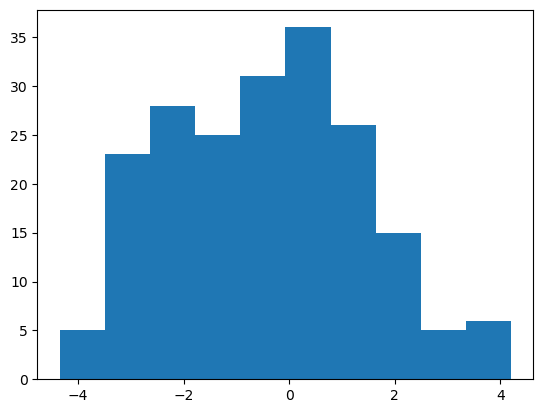

In [277]:
I = 20
T = 10
P = 2
means = np.array([-2,0,2]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal location 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly


mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1
}


In [278]:
true_clus_allocs

array([1., 1., 1., 0., 0., 1., 1., 1., 2., 0., 0., 0., 2., 2., 2., 0., 2.,
       0., 0., 0.])

In [ ]:
fit = dp_mix.sample(data
#                     , show_console = True
                    , chains=4
#                     , adapt_delta=0.9
                    , step_size = 1.5
                    , max_treedepth = 100
                   )

13:44:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/home/daan/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (30), generating only 20 plots
  warnings.warn(


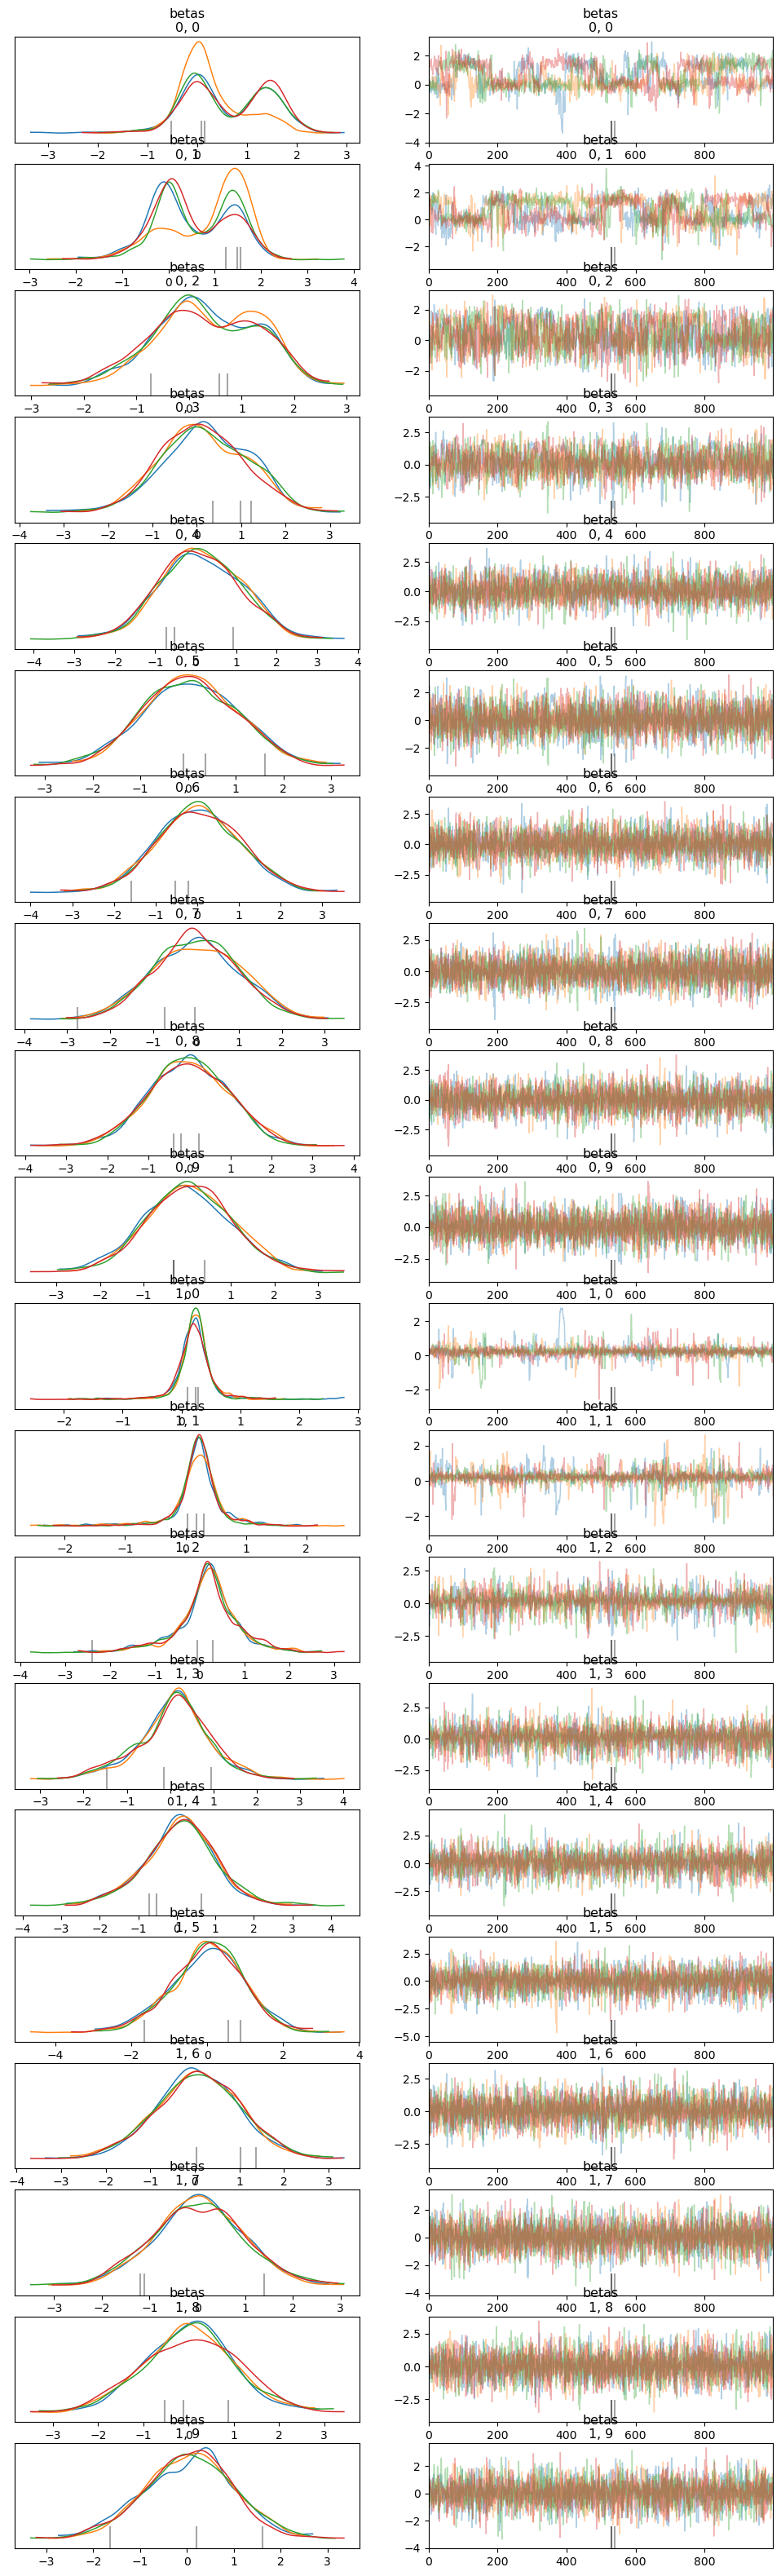

In [275]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()

In [276]:
clus =  np.array(fit_az.posterior.s.values[0, -1, :])
print('s')
print(clus)
print('true clusters')
print(true_clus_allocs)

# once we have sampling from the posterior we can for istance use binder loss for clustering 

s
[5. 2. 1. 1. 2. 2. 1. 1. 2. 2. 5. 1. 5. 4. 5. 1. 1. 1. 1. 1.]
true clusters
[2. 2. 1. 0. 2. 2. 0. 0. 2. 1. 2. 0. 2. 0. 2. 0. 0. 1. 0. 0.]


In [129]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-118.21800,0.331923,10.703400,-136.515000,-117.790000,-101.571000,1039.8500,6.913060,1.00576
alpha,1.69958,0.096607,0.882627,0.585889,1.528040,3.358820,83.4711,0.554928,1.05813
sigma2,1.35474,0.007633,0.450616,0.748325,1.295490,2.145960,3484.7700,23.167200,1.00098
tau2,0.74963,0.013824,0.469440,0.286349,0.623482,1.647480,1153.1000,7.665990,1.00370
rho,0.73963,0.003372,0.155171,0.440079,0.766379,0.943854,2117.4900,14.077400,1.00175
...,...,...,...,...,...,...,...,...,...
"log_probs[10,1]",-28.38480,4.641970,21.162100,-64.469700,-27.088000,-6.227590,20.7831,0.138169,1.19693
"log_probs[10,2]",-24.81530,4.317560,20.662900,-62.557300,-15.283500,-6.253900,22.9038,0.152268,1.16543
"log_probs[10,3]",-26.62640,1.250430,21.610900,-67.422300,-17.685900,-6.779840,298.6960,1.985780,1.03819
"log_probs[10,4]",-24.95780,1.253130,20.056700,-65.296700,-16.391700,-7.179410,256.1700,1.703050,1.02015


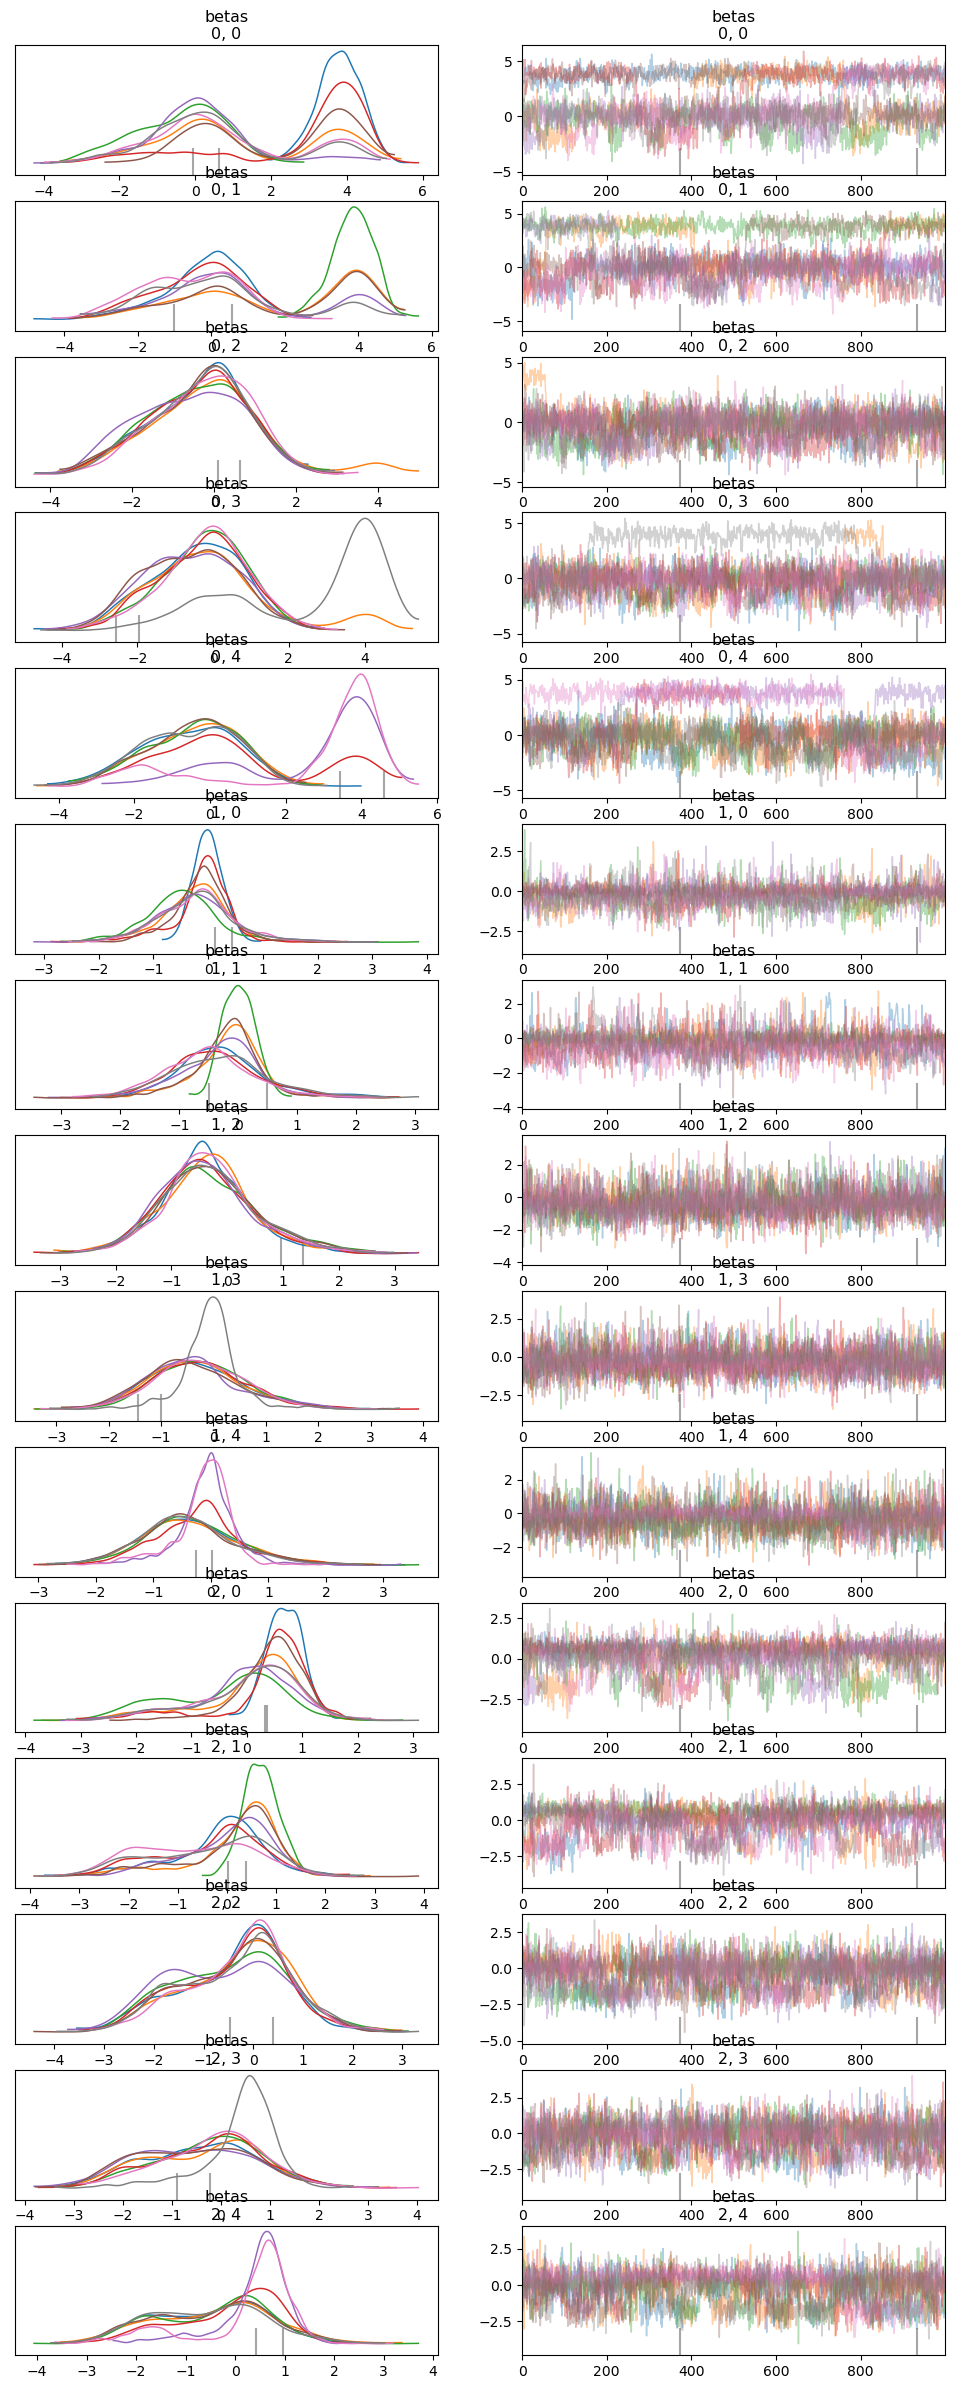

In [152]:

# alcune catene esplorano poco spazio degli stati